# Téma 4: Čo robí filmy obľúbenými a neobľúbenými?

# Module imports

In [ ]:
!pip install opendatasets

In [ ]:
# # imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import gc
from ast import literal_eval
import json

# import opendatasets as od
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from tensorflow.keras import utils, backend as K, callbacks, Sequential, optimizers, layers
from tensorflow import sparse as tfsparse
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
from scipy.stats import shapiro, kstest
from scipy import sparse
import ast
import itertools
from random import *
import re

# Downloading data

In [ ]:
#Kaggle username: jaremcukova
#Kaggle Key: c2b2b48d558542d0591f6bb84257b56e
# od.download("https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset")
# od.download("https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset")

In [ ]:
def get_year(string):
  if type(string) is str:
    return int(string.split('-')[0])
  return string

## Rotten Tomatoes

In [ ]:
url_tomat = "rotten-tomatoes-movies-and-critic-reviews-dataset/rotten_tomatoes_movies.csv"
tomatoes = pd.read_csv(url_tomat)
tomatoes.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'],
      dtype='object')

In [ ]:
tomatoes = tomatoes[[
    'movie_title', 'content_rating', 'genres', 'original_release_date',
    'directors', 'authors', 'actors', 'production_company',
    'tomatometer_rating', 'audience_rating'
    ]]

tomatoes = tomatoes.dropna()
tomatoes['original_release_date'] = tomatoes['original_release_date'].apply(get_year)
print(tomatoes.shape)
tomatoes.head()

(14749, 10)


,movie_title,content_rating,genres,original_release_date,directors,authors,actors,production_company,tomatometer_rating,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",2010,Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",20th Century Fox,49.0,53.0
1,Please Give,R,Comedy,2010,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",Sony Pictures Classics,87.0,64.0
2,10,R,"Comedy, Romance",1979,Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",Waner Bros.,67.0,53.0
3,12 Angry Men (Twelve Angry Men),NR,"Classics, Drama",1957,Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",Criterion Collection,100.0,97.0
4,"20,000 Leagues Under The Sea",G,"Action & Adventure, Drama, Kids & Family",1954,Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",Disney,89.0,74.0


## IMDB

In [ ]:
url_imdb = "the-movies-dataset/movies_metadata.csv"

imdb = pd.read_csv(url_imdb)
imdb.columns

C:\Users\Gabriela\AppData\Local\Temp\ipykernel_13928\2248066080.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb = pd.read_csv(url_imdb)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
imdb = imdb[[
    'title', 'runtime', 'release_date', 'budget', 'spoken_languages', 'overview', 'production_countries',
    'revenue']]
imdb = imdb.dropna()
imdb['release_date'] = imdb['release_date'].apply(get_year)
imdb['budget'] = imdb['budget'].astype('int64')
try:
  imdb['production_countries'] = (
      imdb['production_countries'].apply(literal_eval).apply(
          lambda x: x[0]['name']
          if isinstance(x, list) and len(x) > 0 and 'name' in x[0] else None))
except: pass

print(imdb.shape)
# imdb.head()

(44435, 8)


In [ ]:
# dost vela filmov ma nulovy budget alebo revenue :((
# (zatial ich tam nechavam)
imdb.loc[(imdb['budget']==0) | (imdb['revenue']==0)].shape

(39065, 8)

In [ ]:
movies = pd.merge(tomatoes, imdb, how='inner',
                  left_on=('movie_title', 'original_release_date'),
                  right_on=('title', 'release_date'))
movies.shape

(8854, 18)

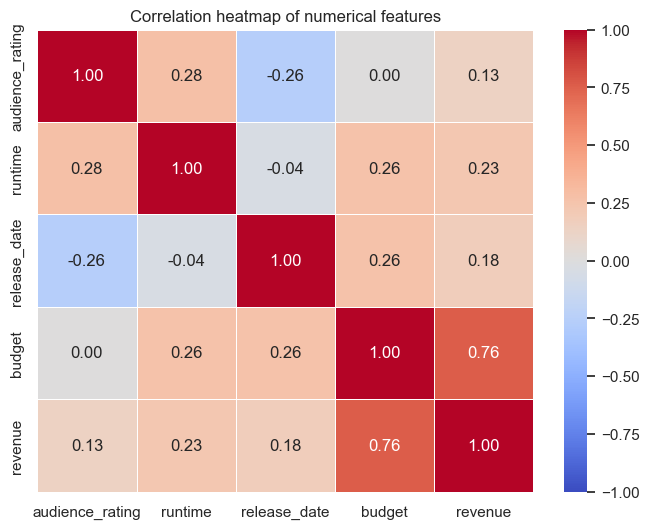

In [ ]:
numerical = movies[['audience_rating','runtime','release_date',	'budget',	'revenue']]
correlation_matrix = numerical.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation heatmap of numerical features')
plt.show()

##Keywords

In [ ]:
url_tomat = "the-movies-dataset/keywords.csv"
df = pd.read_csv(url_tomat)
df['keywords'] = df['keywords'].apply(lambda x: [item['name'] for item in ast.literal_eval(x)])
keywords = pd.concat([df, movies], axis=1).dropna() #[['id','keywords','audience_rating']]
keywords.shape

(8505, 20)

# Model

In [ ]:
utils.set_random_seed(42)

In [ ]:
# rozdelenie na train, test indexy
nrow = movies.shape[0]
indices = np.random.permutation(nrow)
train_i, test_i = indices[:nrow * 4 // 5], indices[nrow * 4 // 5:]

In [ ]:
# preskalovanie vystupov, aby boli medzi 0 a 1
y_train_scaled = np.array(movies.iloc[train_i]['audience_rating']) / 100
y_test_scaled = np.array(movies.iloc[test_i]['audience_rating']) / 100

In [ ]:
# metrics
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
### neuronova siet

def train_nn(train_x, train_y, test_x, test_y, learning_rates=[1e-2, 1e-3, 1e-4, 1e-5]):
    results = []
    # trenovanie sa zastavi ak sa za posledne 3 epochy nezlepsila presnost na validacnych datach
    callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)
    print("Mean Absolute Error on test data (original scale):")
    for lr in learning_rates:
        gc.collect()    # uvolnenie pamate
        # bez skrytych vrstiev, sigmoida na vystupnej -> hodnoty medzi 0 a 1
        model1 = Sequential([
            layers.Dense(1, activation='sigmoid', input_shape=(train_x.shape[1],))
        ])
        # skryta ReLU vrstva
        model2 = Sequential([
                layers.Dense(2, activation='relu', input_shape=(train_x.shape[1],)),
                layers.Dense(1, activation='sigmoid')
        ])
        print(f'lr={lr}', end=' ')
        for i, model in (1, model1), (2, model2):
            model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                          loss='mean_squared_error', metrics=[root_mean_squared_error])
            model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=0,
                      callbacks=[callback], validation_data=(test_x, test_y))
            loss, rmse = model.evaluate(test_x, test_y, verbose=0)
            results.append(rmse * 100)
            print(f'-- {i} --> rmse={rmse * 100:.4f}', end=' ')
        print()
    print(min(results))
    return min(results)

In [ ]:
results = {}

## Actors, directors, authors

In [ ]:
directors = movies['directors'].apply(lambda row: row.split(', '))
authors = movies['authors'].apply(lambda row: row.split(', '))
actors = movies['actors'].apply(lambda row: row.split(', '))

## Actors - visualisation

In [ ]:
mlb = MultiLabelBinarizer()
a_matrix = sparse.csr_matrix(mlb.fit_transform(actors))
weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])
item_ratings_sum = weighted_ratings.T.sum(axis=1).A.ravel()
item_counts = a_matrix.sum(axis=0).A.ravel()

mean_ratings = np.divide(item_ratings_sum, item_counts,
                         out=np.zeros_like(item_ratings_sum), where=item_counts>0)
limit = 30
where_enough = item_counts>limit

where_enough_ratings = mean_ratings[where_enough]
where_enough_actors = mlb.classes_[where_enough]
where_enough_counts = item_counts[where_enough]

ranks_reverse = where_enough_ratings.argsort()[::-1]

sorted_counts = where_enough_counts[ranks_reverse]
sorted_actors = where_enough_actors[ranks_reverse]
sorted_ratings = where_enough_ratings[ranks_reverse]

C:\Users\Gabriela\AppData\Local\Temp\ipykernel_13928\4122051759.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])


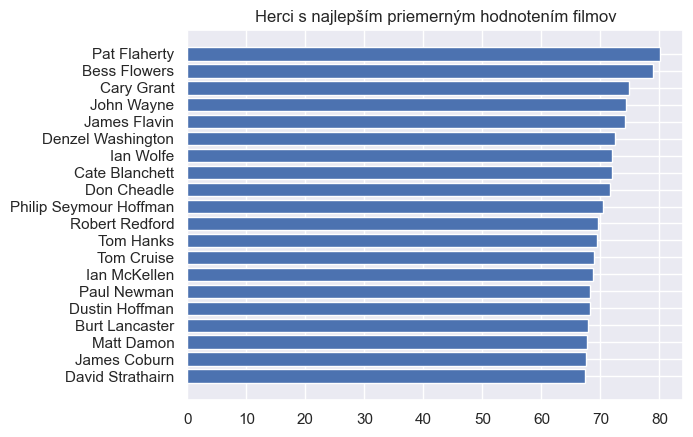

In [ ]:
n = 20
plt.barh(range(n, 0, -1), sorted_ratings[:n])
plt.title('Herci s najlepším priemerným hodnotením filmov')
a = plt.yticks(range(n, 0, -1), sorted_actors[:n])

(array([ 0.,  2., 44., 81., 96., 25.,  8.,  1.,  1.,  0.]),
 array([40., 45., 50., 55., 60., 65., 70., 75., 80., 85., 90.]),
 <BarContainer object of 10 artists>)

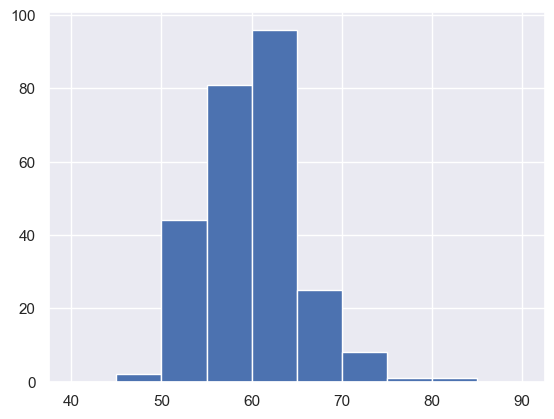

In [ ]:
plt.hist(where_enough_ratings, bins=range(40, 91, 5))

In [ ]:
ratings = list(movies['audience_rating'])
print("Shapiro-Wilk test:", shapiro(sample(ratings, 4000)).pvalue)
print("Kolmogorov-Smirnov test:", kstest(ratings, 'norm').pvalue)

Shapiro-Wilk test: 7.4759376356138345e-28
Kolmogorov-Smirnov test: 0.0


C:\Users\Gabriela\AppData\Local\Temp\ipykernel_13928\3967682101.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])


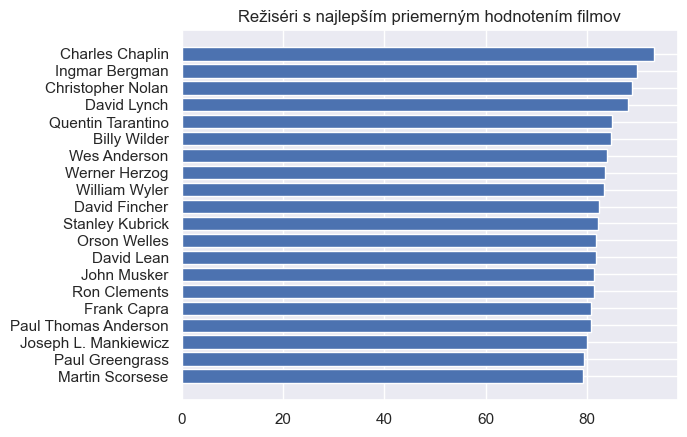

In [ ]:
mlb = MultiLabelBinarizer()
a_matrix = sparse.csr_matrix(mlb.fit_transform(directors))
weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])
item_ratings_sum = weighted_ratings.T.sum(axis=1).A.ravel()
item_counts = a_matrix.sum(axis=0).A.ravel()

mean_ratings = np.divide(item_ratings_sum, item_counts,
                         out=np.zeros_like(item_ratings_sum), where=item_counts>0)
limit = 5
where_enough = item_counts>limit

where_enough_ratings = mean_ratings[where_enough]
where_enough_directors = mlb.classes_[where_enough]
where_enough_counts = item_counts[where_enough]

ranks_reverse = where_enough_ratings.argsort()[::-1]

sorted_counts = where_enough_counts[ranks_reverse]
sorted_directors = where_enough_directors[ranks_reverse]
sorted_ratings = where_enough_ratings[ranks_reverse]

n = 20
plt.barh(range(n, 0, -1), sorted_ratings[:n])
plt.title('Režiséri s najlepším priemerným hodnotením filmov')
a = plt.yticks(range(n, 0, -1), sorted_directors[:n])

In [ ]:
mlb = MultiLabelBinarizer()
# matica filmy x herci, 1 ak herec hra vo filme, 0 ak nie
A = mlb.fit_transform(actors)
A = sparse.csr_matrix(A)    # kvoli pamati
results['actors'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):

lr=0.01 WARNING:tensorflow:From C:\Users\Gabriela\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.


-- 1 --> rmse=22.5647 -- 2 --> rmse=18.7317 
lr=0.001 -- 1 --> rmse=18.6773 -- 2 --> rmse=18.7425 
lr=0.0001 -- 1 --> rmse=18.6000 -- 2 --> rmse=18.6141 
lr=1e-05 -- 1 --> rmse=19.1305 -- 2 --> rmse=21.3958 
lr=1e-06 -- 1 --> rmse=21.6980 -- 2 --> rmse=22.1824 
18.60000193119049


In [ ]:
# pokus dat vyssiu vahu hercom, ktori hraju najvyznamnejsie roly vo filme
mlb = MultiLabelBinarizer()
mlb.fit(actors)
A = sparse.csr_matrix(4 * sparse.csr_matrix(mlb.transform(actors.apply(lambda lst: lst[0:1])))
      + 3 * sparse.csr_matrix(mlb.transform(actors.apply(lambda lst: lst[1:3])))
      + 2 * sparse.csr_matrix(mlb.transform(actors.apply(lambda lst: lst[3:5])))
      + sparse.csr_matrix(mlb.transform(actors.apply(lambda lst: lst[5:]))))
results['actors weighted'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=26.7024 -- 2 --> rmse=18.8636 
lr=0.001 -- 1 --> rmse=18.7285 -- 2 --> rmse=18.9640 
lr=0.0001 -- 1 --> rmse=18.6120 -- 2 --> rmse=18.6278 
lr=1e-05 -- 1 --> rmse=18.8144 -- 2 --> rmse=18.7050 
lr=1e-06 -- 1 --> rmse=21.5202 -- 2 --> rmse=21.3424 
18.612040579319


In [ ]:
# main character
mlb = MultiLabelBinarizer()
mlb.fit(actors)
A = (sparse.csr_matrix(mlb.transform(actors.apply(lambda lst: lst[0:1]))))
results['actor - main character'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.4647 -- 2 --> rmse=19.8266 
lr=0.001 -- 1 --> rmse=19.1636 -- 2 --> rmse=19.4128 
lr=0.0001 -- 1 --> rmse=19.2357 -- 2 --> rmse=19.1812 
lr=1e-05 -- 1 --> rmse=20.4521 -- 2 --> rmse=19.8015 
lr=1e-06 -- 1 --> rmse=22.1172 -- 2 --> rmse=21.6140 
19.163550436496735


In [ ]:
# directors
mlb = MultiLabelBinarizer()
A = sparse.csr_matrix(mlb.fit_transform(directors))
results['directors'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=18.9860 -- 2 --> rmse=19.6209 
lr=0.001 -- 1 --> rmse=18.8105 -- 2 --> rmse=19.2495 
lr=0.0001 -- 1 --> rmse=18.9864 -- 2 --> rmse=18.8214 
lr=1e-05 -- 1 --> rmse=20.4233 -- 2 --> rmse=19.8183 
lr=1e-06 -- 1 --> rmse=22.1016 -- 2 --> rmse=21.7064 
18.810464441776276


In [ ]:
# authors
mlb = MultiLabelBinarizer()
A = sparse.csr_matrix(mlb.fit_transform(authors))
results['authors'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.6124 -- 2 --> rmse=20.9031 
lr=0.001 -- 1 --> rmse=19.1971 -- 2 --> rmse=19.6058 
lr=0.0001 -- 1 --> rmse=19.1913 -- 2 --> rmse=19.4419 
lr=1e-05 -- 1 --> rmse=20.4384 -- 2 --> rmse=19.5966 
lr=1e-06 -- 1 --> rmse=22.0807 -- 2 --> rmse=21.5823 
19.191288948059082


In [ ]:
# directors+authors+actors
mlb = MultiLabelBinarizer()
mlb.fit(directors+authors+actors)
A = sparse.hstack((
      sparse.csr_matrix(mlb.transform(directors)),
      sparse.csr_matrix(mlb.transform(authors)),
      sparse.csr_matrix(mlb.fit_transform(actors))
))
results['directors, authors, actors'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=23.0952 -- 2 --> rmse=18.4299 
lr=0.001 -- 1 --> rmse=18.3299 -- 2 --> rmse=18.7092 
lr=0.0001 -- 1 --> rmse=18.3208 -- 2 --> rmse=18.3323 
lr=1e-05 -- 1 --> rmse=18.9478 -- 2 --> rmse=18.5086 
lr=1e-06 -- 1 --> rmse=21.6347 -- 2 --> rmse=22.2851 
18.320824205875397


## Words used in overview

C:\Users\Gabriela\AppData\Local\Temp\ipykernel_13928\4091744353.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])


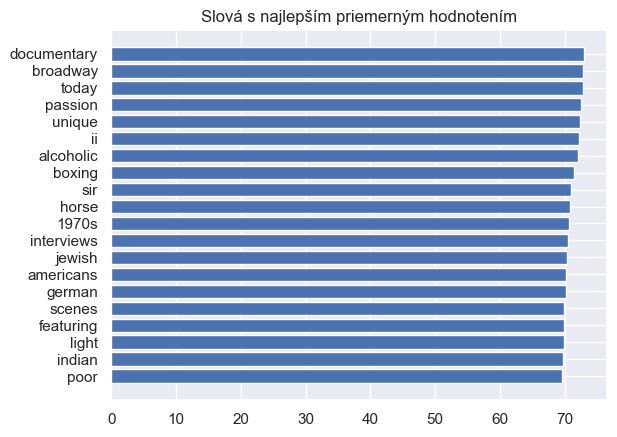

In [ ]:
cv = CountVectorizer()
a_matrix = sparse.csr_matrix(cv.fit_transform(movies['overview']))
words = cv.get_feature_names_out()

weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])
item_ratings_sum = weighted_ratings.T.sum(axis=1).A.ravel()
item_counts = a_matrix.sum(axis=0).A.ravel()

mean_ratings = np.divide(item_ratings_sum, item_counts,
                         out=np.zeros_like(item_ratings_sum), where=item_counts>0)

limit = 30
where_enough = item_counts>limit

where_enough_ratings = mean_ratings[where_enough]
where_enough_words = words[where_enough]
where_enough_counts = item_counts[where_enough]

ranks_reverse = where_enough_ratings.argsort()[::-1]
sorted_words = where_enough_words[ranks_reverse]
sorted_ratings = where_enough_ratings[ranks_reverse]

fig, ax = plt.subplots()
ax.barh(range(20, 0, -1), sorted_ratings[:20])
ax.set_title('Slová s najlepším priemerným hodnotením')
a = ax.set_yticks(range(20, 0, -1), sorted_words[:20])

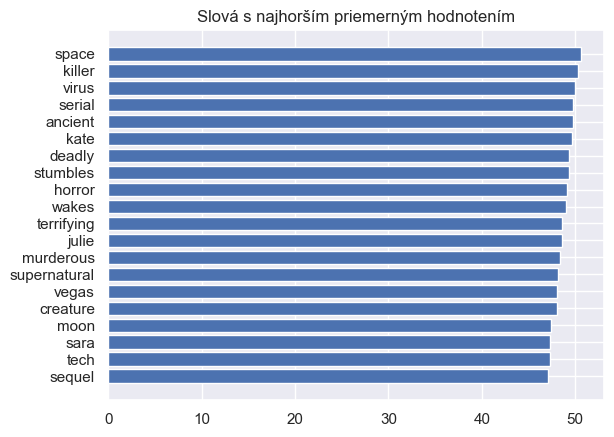

In [ ]:
fig, ax = plt.subplots()
ax.barh(range(20, 0, -1), sorted_ratings[-20:])
ax.set_title('Slová s najhorším priemerným hodnotením')
a = ax.set_yticks(range(20, 0, -1), sorted_words[-20:])

In [ ]:
cv = CountVectorizer()
A = cv.fit_transform(movies['overview'])
Atrain, Atest = sparse.csr_matrix(A[train_i]), sparse.csr_matrix(A[test_i])

Atrain = tfsparse.reorder(tfsparse.SparseTensor(
    indices=np.column_stack(Atrain.nonzero()),
    values=Atrain.data,
    dense_shape=Atrain.shape
))

Atest = tfsparse.reorder(tfsparse.SparseTensor(
    indices=np.column_stack(Atest.nonzero()),
    values=Atest.data,
    dense_shape=Atest.shape
))
results['words in overview'] = train_nn(Atrain, y_train_scaled, Atest, y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=23.7039 -- 2 --> rmse=20.4045 
lr=0.001 -- 1 --> rmse=19.5779 -- 2 --> rmse=20.7441 
lr=0.0001 -- 1 --> rmse=19.1971 -- 2 --> rmse=19.7432 
lr=1e-05 -- 1 --> rmse=19.4277 -- 2 --> rmse=19.2549 
lr=1e-06 -- 1 --> rmse=20.3151 -- 2 --> rmse=20.2349 
19.19713169336319


In [ ]:
#počet slov v overview
lenghts = movies['overview'].apply(lambda lst: len(re.sub(r'[^a-zA-Z0-9 ]', '', lst).split()))
movies['overview_len'] = lenghts
Wtrain = movies.iloc[train_i]['overview_len']
Wtrain = np.reshape(Wtrain.values, (-1, 1))
Wtest = movies.iloc[test_i]['overview_len']
Wtest = np.reshape(Wtest.values, (-1, 1))

In [ ]:
results['(overview) number of words'] = train_nn(Wtrain, y_train_scaled, Wtest, y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=20.3007 -- 2 --> rmse=19.8395 
lr=0.001 -- 1 --> rmse=19.9225 -- 2 --> rmse=19.8252 
lr=0.0001 -- 1 --> rmse=19.8519 -- 2 --> rmse=19.8242 
lr=1e-05 -- 1 --> rmse=44.0039 -- 2 --> rmse=20.7182 
lr=1e-06 -- 1 --> rmse=44.0028 -- 2 --> rmse=63.4538 
19.82419788837433


## Genre, release date, runtime, rating


C:\Users\Gabriela\AppData\Local\Temp\ipykernel_13928\3391134620.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])


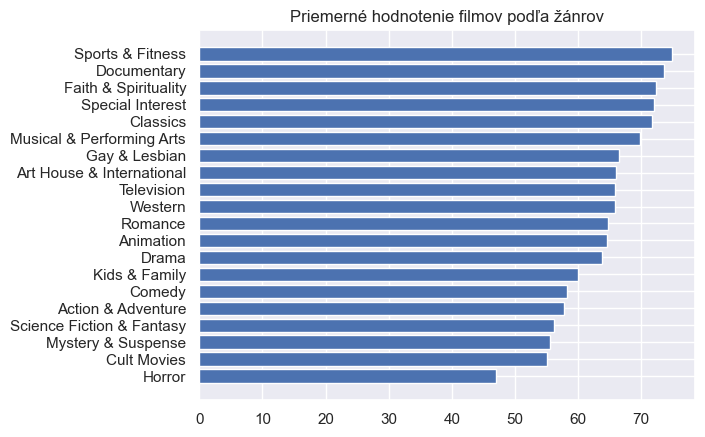

In [ ]:
mlb = MultiLabelBinarizer()
genres = movies['genres'].apply(lambda row: row.split(', '))
a_matrix = sparse.csr_matrix(mlb.fit_transform(genres)) # matica filmy x zanre, 1 ak film patri do daneho zanra, 0 ak nie
classes_genres = mlb.classes_

weighted_ratings = a_matrix.multiply(movies.audience_rating[:, np.newaxis])
item_ratings_sum = weighted_ratings.T.sum(axis=1).A.ravel()
item_counts = a_matrix.sum(axis=0).A.ravel()

mean_ratings = np.divide(item_ratings_sum, item_counts,
                         out=np.zeros_like(item_ratings_sum), where=item_counts>0)

ranks = mean_ratings.argsort()
sorted_genres = classes_genres[ranks]
sorted_ratings = mean_ratings[ranks]

fig, ax = plt.subplots()
ax.barh(np.arange(classes_genres.shape[0]), sorted_ratings)
ax.set_title('Priemerné hodnotenie filmov podľa žánrov')
a = ax.set_yticks(np.arange(classes_genres.shape[0]), sorted_genres)
# ax.set_ylabel('Žánre')
# ax.set_xlabel('Priemerné hodnotenie')


In [ ]:
mlb1 = MultiLabelBinarizer()
genres = movies['genres'].apply(lambda row: row.split(', '))
G = mlb1.fit_transform(genres) # matica filmy x zanre, 1 ak film patri do daneho zanra, 0 ak nie
classes_genres = mlb1.classes_   #nazvy zanrov

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
ratings =  movies[['content_rating']]
R = onehot_encoder.fit_transform(ratings)   #matica filmy x rating, 1 ak film patri do ratingu, 0 ak nie
classes_ratings = onehot_encoder.get_feature_names_out() #nazvy ratingov

C:\Users\Gabriela\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
df_genre = movies[['runtime', 'release_date']]
new_data1 = {'content_rating_G':R[:,0], 'content_rating_NC17':R[:,1], 'content_rating_NR':R[:,2],
 'content_rating_PG':R[:,3], 'content_rating_PG-13':R[:,4], 'content_rating_R':R[:,5]}
df = df_genre.assign(**new_data1)
new_data2 = {'Action & Adventure':G[:,0], 'Animation':G[:,1], 'Art House & International':G[:,2], 'Classics':G[:,3],
 'Comedy':G[:,4], 'Cult Movies':G[:,5], 'Documentary':G[:,6], 'Drama':G[:,7], 'Faith & Spirituality':G[:,8],
 'Gay & Lesbian':G[:,9], 'Horror':G[:,10], 'Kids & Family':G[:,11], 'Musical & Performing Arts':G[:,12],
 'Mystery & Suspense':G[:,13], 'Romance':G[:,14], 'Science Fiction & Fantasy':G[:,15],
 'Special Interest':G[:,16], 'Sports & Fitness':G[:,17], 'Television':G[:,18], 'Western':G[:,19]}
df_ff = df.assign(**new_data2)
df_f = df_ff.assign(audience_score=movies['audience_rating'])
df_f #dataset so stlpcami runtime, release_date, audience rating, pre kazdy druh ratingu 1 stlpec (1/0) a pre kazdy druh zanra jeden stlpec (1/0)

,runtime,release_date,content_rating_G,content_rating_NC17,content_rating_NR,content_rating_PG,content_rating_PG-13,content_rating_R,Action & Adventure,Animation,...,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,audience_score
0,118.0,2010,0.0,0.0,0.0,1.0,0.0,0.0,1,0,...,0,0,0,0,1,0,0,0,0,53.0
1,90.0,2010,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,64.0
2,122.0,1979,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,0,1,0,0,0,0,0,53.0
3,86.0,1935,0.0,0.0,1.0,0.0,0.0,0.0,1,0,...,0,0,1,0,0,0,0,0,0,86.0
4,92.0,1957,0.0,0.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849,83.0,2006,0.0,0.0,0.0,1.0,0.0,0.0,1,0,...,1,0,0,0,0,0,0,0,0,33.0
8850,103.0,1981,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,74.0
8851,108.0,2016,0.0,0.0,0.0,1.0,0.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,92.0
8852,138.0,1964,0.0,0.0,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,91.0


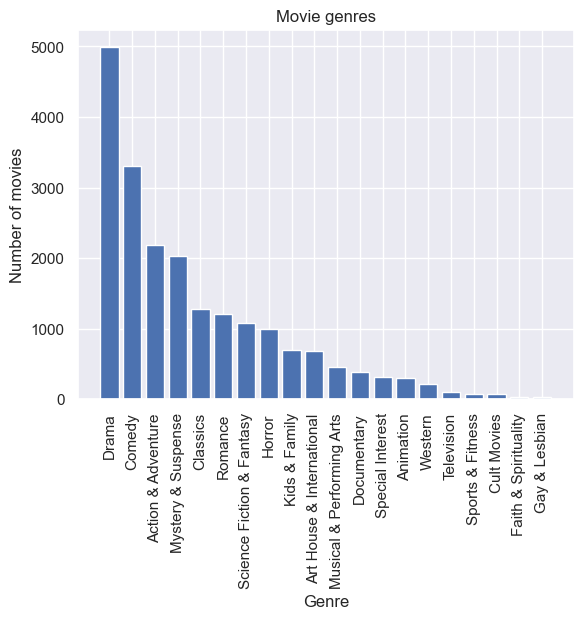

In [ ]:
genres_df = df_f[['Action & Adventure', 'Animation',
       'Art House & International', 'Classics', 'Comedy', 'Cult Movies',
       'Documentary', 'Drama', 'Faith & Spirituality', 'Gay & Lesbian',
       'Horror', 'Kids & Family', 'Musical & Performing Arts',
       'Mystery & Suspense', 'Romance', 'Science Fiction & Fantasy',
       'Special Interest', 'Sports & Fitness', 'Television', 'Western']]

genre_sums = genres_df.sum().sort_values(ascending=False)

plt.bar(genre_sums.index, genre_sums.values)

plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Movie genres')
plt.xticks(rotation=90)
plt.show()

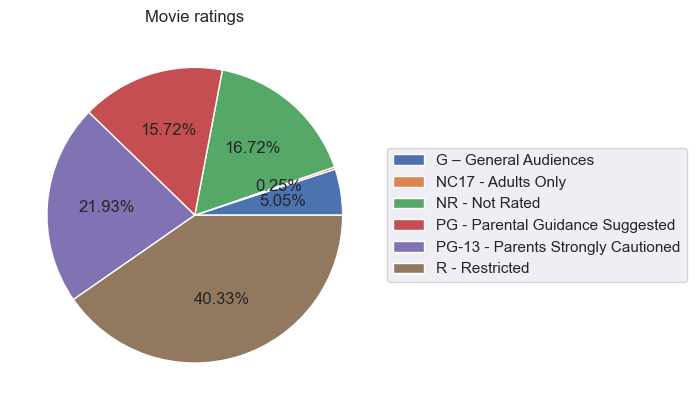

In [ ]:
ratings_df = df_f[['content_rating_G', 'content_rating_NC17',
       'content_rating_NR', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R']]

rating_sums = ratings_df.sum()
rating_labels = ['G – General Audiences', 'NC17 - Adults Only','NR - Not Rated', 'PG - Parental Guidance Suggested', 'PG-13 - Parents Strongly Cautioned','R - Restricted']
plt.pie(rating_sums.values, autopct='%1.2f%%')
plt.title('Movie ratings')
plt.legend(rating_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

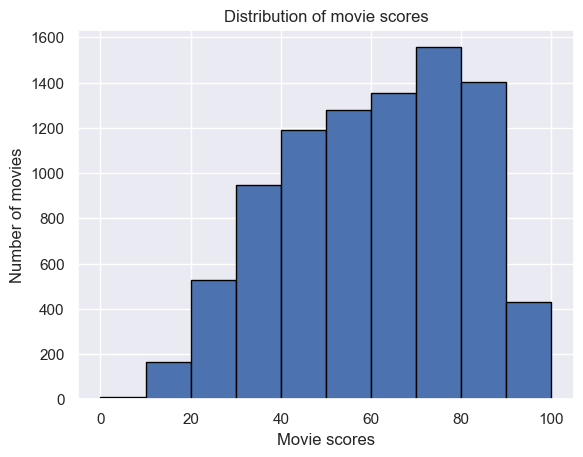

In [ ]:
plt.hist(df_f['audience_score'],bins=range(0, 101, 10),edgecolor='black')
plt.xlabel('Movie scores')
plt.ylabel('Number of movies')
plt.title('Distribution of movie scores')
plt.show()

In [ ]:
#testy normality, obe normalitu zamietli
ratings = list(df_f['audience_score'])
print("Shapiro-Wilk test: ", shapiro(sample(ratings, 4000)).pvalue)
print("Kolmogorov-Smirnov test: ", kstest(ratings, 'norm').pvalue)

Shapiro-Wilk test:  1.1591280629702521e-27
Kolmogorov-Smirnov test:  0.0


In [ ]:
#atributy: žáner, rok vydania, trvanie, rating
G_all = df_f.drop('audience_score', axis=1)
G_all = sparse.csr_matrix(G_all)
results['genre, release date, runtime, rating'] = train_nn(G_all[train_i], y_train_scaled, G_all[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=63.5373 -- 2 --> rmse=19.8496 
lr=0.001 -- 1 --> rmse=63.5373 -- 2 --> rmse=19.8295 
lr=0.0001 -- 1 --> rmse=63.5373 -- 2 --> rmse=19.8280 
lr=1e-05 -- 1 --> rmse=44.0043 -- 2 --> rmse=63.5373 
lr=1e-06 -- 1 --> rmse=44.0043 -- 2 --> rmse=63.5373 
19.827984273433685


In [ ]:
#atributy: žáner
G_genres = df_f[['Action & Adventure','Animation','Art House & International','Classics','Comedy','Cult Movies','Documentary','Drama','Faith & Spirituality'
 ,'Gay & Lesbian','Horror','Kids & Family','Musical & Performing Arts','Mystery & Suspense','Romance','Science Fiction & Fantasy'
 ,'Special Interest','Sports & Fitness','Television','Western']]
G_genres = sparse.csr_matrix(G_genres)
results['genre'] = train_nn(G_genres[train_i], y_train_scaled, G_genres[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=17.9408 -- 2 --> rmse=17.7635 
lr=0.001 -- 1 --> rmse=17.8599 -- 2 --> rmse=17.8525 
lr=0.0001 -- 1 --> rmse=17.8697 -- 2 --> rmse=18.7482 
lr=1e-05 -- 1 --> rmse=21.7579 -- 2 --> rmse=19.8041 
lr=1e-06 -- 1 --> rmse=21.9175 -- 2 --> rmse=21.9372 
17.76350736618042


In [ ]:
#atributy: rating
G_ratings = df_f[['content_rating_G', 'content_rating_NC17', 'content_rating_NR',
 'content_rating_PG', 'content_rating_PG-13', 'content_rating_R']]
G_ratings = sparse.csr_matrix(G_ratings)
results['rating'] = train_nn(G_ratings[train_i], y_train_scaled, G_ratings[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.6187 -- 2 --> rmse=19.5663 
lr=0.001 -- 1 --> rmse=19.5277 -- 2 --> rmse=19.8100 
lr=0.0001 -- 1 --> rmse=19.5540 -- 2 --> rmse=19.5842 
lr=1e-05 -- 1 --> rmse=20.1159 -- 2 --> rmse=20.6313 
lr=1e-06 -- 1 --> rmse=27.5894 -- 2 --> rmse=21.0952 
19.52768862247467


In [ ]:
#atributy: dlzka filmu
G_runtime = df_f[['runtime']]
G_runtime = sparse.csr_matrix(G_runtime)
results['runtime'] = train_nn(G_runtime[train_i], y_train_scaled, G_runtime[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.1218 -- 2 --> rmse=63.4745 
lr=0.001 -- 1 --> rmse=63.4725 -- 2 --> rmse=19.8279 
lr=0.0001 -- 1 --> rmse=43.9063 -- 2 --> rmse=43.9063 
lr=1e-05 -- 1 --> rmse=43.9063 -- 2 --> rmse=63.4723 
lr=1e-06 -- 1 --> rmse=63.4724 -- 2 --> rmse=43.9063 
19.121822714805603


In [ ]:
#atributy: rok vydania
G_release_date = df_f[['release_date']]
G_release_date = sparse.csr_matrix(G_release_date)
results['release date'] = train_nn(G_release_date[train_i], y_train_scaled, G_release_date[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=63.5373 -- 2 --> rmse=44.0043 
lr=0.001 -- 1 --> rmse=44.0043 -- 2 --> rmse=19.8270 
lr=0.0001 -- 1 --> rmse=63.5373 -- 2 --> rmse=19.8277 
lr=1e-05 -- 1 --> rmse=63.5373 -- 2 --> rmse=20.5916 
lr=1e-06 -- 1 --> rmse=63.5373 -- 2 --> rmse=22.1333 
19.826997816562653


## Language and Country

In [ ]:
languages = movies['spoken_languages'].apply(lambda lst: [d['name'] for d in json.loads(lst.replace("'", "\""))])
countries = movies['production_countries'].apply(lambda lst: lst.split(',') if lst is not None else [])

In [ ]:
mlb = MultiLabelBinarizer()
L = sparse.csr_matrix(mlb.fit_transform(languages))
results['language'] = train_nn(L[train_i], y_train_scaled, L[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.7425 -- 2 --> rmse=19.7241 
lr=0.001 -- 1 --> rmse=19.7387 -- 2 --> rmse=19.7043 
lr=0.0001 -- 1 --> rmse=19.6876 -- 2 --> rmse=19.7197 
lr=1e-05 -- 1 --> rmse=19.9799 -- 2 --> rmse=20.2219 
lr=1e-06 -- 1 --> rmse=24.3682 -- 2 --> rmse=21.0449 
19.687604904174805


In [ ]:
mlb = MultiLabelBinarizer()
C = sparse.csr_matrix(mlb.fit_transform(countries))
results['country'] = train_nn(C[train_i], y_train_scaled, C[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.7271 -- 2 --> rmse=19.8220 
lr=0.001 -- 1 --> rmse=19.7075 -- 2 --> rmse=19.7201 
lr=0.0001 -- 1 --> rmse=19.7558 -- 2 --> rmse=19.8106 
lr=1e-05 -- 1 --> rmse=20.3927 -- 2 --> rmse=19.9875 
19.70747709274292


In [ ]:
mlb = MultiLabelBinarizer()
M = sparse.csr_matrix(mlb.fit_transform(languages+countries))
results['language, country'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.7133 -- 2 --> rmse=19.6147 
lr=0.001 -- 1 --> rmse=19.6030 -- 2 --> rmse=19.6224 
lr=0.0001 -- 1 --> rmse=19.6712 -- 2 --> rmse=19.6027 
lr=1e-05 -- 1 --> rmse=20.0328 -- 2 --> rmse=19.8568 
19.60272341966629


## Keywords

In [ ]:
#veľa filmov nemá priradené kľúčové slová
sum(keywords['keywords'].apply(lambda k: len(k) > 0))

7365

In [ ]:
keywords = keywords[keywords['keywords'].apply(lambda x: len(x) > 0)]

In [ ]:
nrow = keywords.shape[0]
indices = np.random.permutation(nrow)
train_i, test_i = indices[:nrow * 4 // 5], indices[nrow * 4 // 5:]
# preskalovanie vystupov, aby boli medzi 0 a 1
y_train_scaled = np.array(keywords.iloc[train_i]['audience_rating']) / 100
y_test_scaled = np.array(keywords.iloc[test_i]['audience_rating']) / 100

C:\Users\Gabriela\AppData\Local\Temp\ipykernel_13928\3329912422.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_ratings = a_matrix.multiply(keywords.audience_rating[:, np.newaxis])


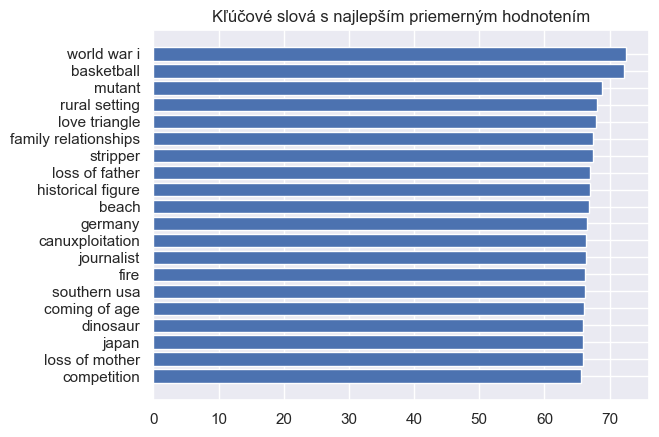

In [ ]:
mlb = MultiLabelBinarizer()
a_matrix = sparse.csr_matrix(mlb.fit_transform(keywords['keywords']))
words = mlb.classes_

weighted_ratings = a_matrix.multiply(keywords.audience_rating[:, np.newaxis])
item_ratings_sum = weighted_ratings.T.sum(axis=1).A.ravel()
item_counts = a_matrix.sum(axis=0).A.ravel()
# plt.hist(item_counts, bins=range(0, 101, 5))
mean_ratings = np.divide(item_ratings_sum, item_counts,
                         out=np.zeros_like(item_ratings_sum), where=item_counts>0)
limit = 20
where_enough = item_counts>limit

where_enough_ratings = mean_ratings[where_enough]
where_enough_words = words[where_enough]
where_enough_counts = item_counts[where_enough]

ranks_reverse = where_enough_ratings.argsort()[::-1]
sorted_words = where_enough_words[ranks_reverse]
sorted_ratings = where_enough_ratings[ranks_reverse]

fig, ax = plt.subplots()
ax.barh(range(20, 0, -1), sorted_ratings[:20])
ax.set_title('Kľúčové slová s najlepším priemerným hodnotením')
a = ax.set_yticks(range(20, 0, -1), sorted_words[:20])

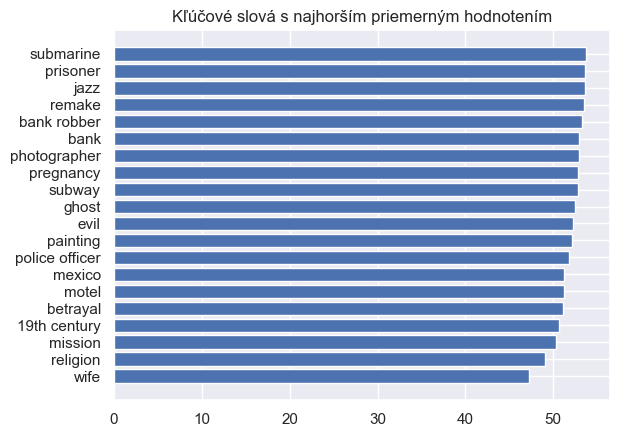

In [ ]:
fig, ax = plt.subplots()
ax.barh(range(20, 0, -1), sorted_ratings[-20:])
ax.set_title('Kľúčové slová s najhorším priemerným hodnotením')
a = ax.set_yticks(range(20, 0, -1), sorted_words[-20:])

In [ ]:
def weight(value):
    def assign_weights_to_sublist(sublist):
        return [5-i if i < 4 else 1 for i, _ in enumerate(sublist)]

    # Apply the weight assignment function to each sublist in the column
    weighted_column = value.apply(assign_weights_to_sublist)

    # Use MultiLabelBinarizer to transform the weighted keywords
    mlb = MultiLabelBinarizer()
    weighted_matrix = mlb.fit_transform(weighted_column)

    # Convert to sparse matrix for memory efficiency
    weighted_matrix_sparse = sparse.csr_matrix(weighted_matrix)

    return weighted_matrix_sparse

In [ ]:
#všetky kľúčové slová
key = keywords['keywords']
mlb2 = MultiLabelBinarizer()
M = mlb2.fit_transform(key)
M = sparse.csr_matrix(M)
results['keywords'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=23.0109 -- 2 --> rmse=23.4189 
lr=0.001 -- 1 --> rmse=21.0356 -- 2 --> rmse=21.3760 
lr=0.0001 -- 1 --> rmse=20.9097 -- 2 --> rmse=20.8386 
lr=1e-05 -- 1 --> rmse=21.2537 -- 2 --> rmse=21.0714 
20.83863765001297


In [ ]:
#s váhami
mlb2 = MultiLabelBinarizer()
M = weight(key)
results['keywords weighted'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=20.8036 -- 2 --> rmse=20.7784 
lr=0.001 -- 1 --> rmse=20.7598 -- 2 --> rmse=20.7370 
lr=0.0001 -- 1 --> rmse=21.0550 -- 2 --> rmse=20.7673 
lr=1e-05 -- 1 --> rmse=36.3468 -- 2 --> rmse=21.1399 
20.737038552761078


In [ ]:
#len slová písané latinkou
key = keywords['keywords'].apply(lambda words: [ w for w in words if w.isalpha() ])
mlb2 = MultiLabelBinarizer()
M = mlb2.fit_transform(key)
M = sparse.csr_matrix(M)
results['keywords latin'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=22.6018 -- 2 --> rmse=23.2629 
lr=0.001 -- 1 --> rmse=21.0814 -- 2 --> rmse=21.0600 
lr=0.0001 -- 1 --> rmse=20.9508 -- 2 --> rmse=20.9042 
lr=1e-05 -- 1 --> rmse=21.4042 -- 2 --> rmse=20.9227 
20.904244482517242


In [ ]:
#len prvých 5
key = keywords['keywords'].apply(lambda words: words[:5])
mlb2 = MultiLabelBinarizer()
M = mlb2.fit_transform(key)
M = sparse.csr_matrix(M)
results['keywords 5'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=22.5998 -- 2 --> rmse=21.0882 
lr=0.001 -- 1 --> rmse=20.9047 -- 2 --> rmse=21.2320 
lr=0.0001 -- 1 --> rmse=20.8091 -- 2 --> rmse=20.7863 
lr=1e-05 -- 1 --> rmse=21.2250 -- 2 --> rmse=20.7918 
20.78630179166794


In [ ]:
#s váhami
mlb2 = MultiLabelBinarizer()
mlb2.fit(key)
M = weight(key)
results['keywords 5 weighted'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=20.9442 -- 2 --> rmse=20.7770 
lr=0.001 -- 1 --> rmse=20.7568 -- 2 --> rmse=20.7759 
lr=0.0001 -- 1 --> rmse=21.3711 -- 2 --> rmse=20.7657 
lr=1e-05 -- 1 --> rmse=21.6977 -- 2 --> rmse=21.5788 
20.756801962852478


In [ ]:
#len prvých 10
key = keywords['keywords'].apply(lambda words: words[:10])
mlb2 = MultiLabelBinarizer()
M = mlb2.fit_transform(key)
M = sparse.csr_matrix(M)
results['keywords 10'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=23.0829 -- 2 --> rmse=23.5812 
lr=0.001 -- 1 --> rmse=20.9677 -- 2 --> rmse=21.1082 
lr=0.0001 -- 1 --> rmse=20.8715 -- 2 --> rmse=20.8617 
lr=1e-05 -- 1 --> rmse=21.1733 -- 2 --> rmse=20.8571 
20.85709124803543


In [ ]:
#s váhami
mlb2 = MultiLabelBinarizer()
mlb2.fit(key)
M = weight(key)
results['keywords 10 weighted'] = train_nn(M[train_i], y_train_scaled, M[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=20.7954 -- 2 --> rmse=20.7698 
lr=0.001 -- 1 --> rmse=20.7624 -- 2 --> rmse=20.7659 
lr=0.0001 -- 1 --> rmse=21.0350 -- 2 --> rmse=20.7414 
lr=1e-05 -- 1 --> rmse=22.1424 -- 2 --> rmse=21.7191 
20.74144184589386


## Director, author, studio, budget

In [ ]:
# rozdelenie na train, test indexy
nrow = movies.shape[0]
indices = np.random.permutation(nrow)
train_i, test_i = indices[:nrow * 4 // 5], indices[nrow * 4 // 5:]
# preskalovanie vystupov, aby boli medzi 0 a 1
y_train_scaled = np.array(movies.iloc[train_i]['audience_rating']) / 100
y_test_scaled = np.array(movies.iloc[test_i]['audience_rating']) / 100

In [ ]:
onehot_encoder2 = OneHotEncoder(sparse=False)
dir =  movies[['directors']]
Dir = onehot_encoder2.fit_transform(dir)

C:\Users\Gabriela\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
mlb3 = MultiLabelBinarizer()
aut = movies['authors'].apply(lambda row: row.split(', '))
Aut = mlb3.fit_transform(aut)

In [ ]:
onehot_encoder3 = OneHotEncoder(sparse=False)
com =  movies[['production_company']]
Com = onehot_encoder3.fit_transform(com)

C:\Users\Gabriela\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
Bud = movies['budget'].values.reshape(-1, 1)
S1 = np.concatenate((Dir,Aut,Com,Bud), axis=1)

In [ ]:
#atributy: reziser,autori,studio, budget
mat = sparse.csr_matrix(S1)
results['director, author, production company, budget'] = train_nn(mat[train_i], y_train_scaled, mat[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=34.4993 -- 2 --> rmse=20.3279 
lr=0.001 -- 1 --> rmse=47.4309 -- 2 --> rmse=20.2337 
lr=0.0001 -- 1 --> rmse=34.2728 -- 2 --> rmse=20.0518 
lr=1e-05 -- 1 --> rmse=34.6609 -- 2 --> rmse=20.6999 
20.05176991224289


In [ ]:
#atributy: reziser,autori,studio - bez budget, lebo je velakrat 0
S2 = np.concatenate((Dir,Aut,Com), axis=1)
S2 = sparse.csr_matrix(S2)
results['director, author, production company'] = train_nn(S2[train_i], y_train_scaled, S2[test_i], y_test_scaled)


Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.3770 -- 2 --> rmse=20.1827 
lr=0.001 -- 1 --> rmse=18.8389 -- 2 --> rmse=19.3368 
lr=0.0001 -- 1 --> rmse=18.8058 -- 2 --> rmse=18.8312 
lr=1e-05 -- 1 --> rmse=20.3118 -- 2 --> rmse=19.9345 
18.80580633878708


In [ ]:
Com_sp = sparse.csr_matrix(Com)
results['production company'] = train_nn(Com_sp[train_i], y_train_scaled, Com_sp[test_i], y_test_scaled)

Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=19.9665 -- 2 --> rmse=20.1391 
lr=0.001 -- 1 --> rmse=19.7743 -- 2 --> rmse=19.8483 
lr=0.0001 -- 1 --> rmse=19.8370 -- 2 --> rmse=19.8151 
lr=1e-05 -- 1 --> rmse=20.5715 -- 2 --> rmse=20.3817 
19.774268567562103


In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(directors+authors+actors)

onehot_encoder3 = OneHotEncoder(sparse=False)
com =  movies[['production_company']]
Com = onehot_encoder3.fit_transform(com)

mlb1 = MultiLabelBinarizer()
genres = movies['genres'].apply(lambda row: row.split(', '))
G = mlb1.fit_transform(genres)

A = sparse.hstack((
      sparse.csr_matrix(mlb.transform(directors)),
      sparse.csr_matrix(mlb.transform(authors)),
      sparse.csr_matrix(mlb.fit_transform(actors)),
      sparse.csr_matrix(G_runtime),
      sparse.csr_matrix(Com),
      sparse.csr_matrix(G),
))

results['director, author, actors, production company, genre, runtime'] = train_nn(A[train_i], y_train_scaled, A[test_i], y_test_scaled)

C:\Users\Gabriela\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Mean Absolute Error on test data (original scale):
lr=0.01 -- 1 --> rmse=22.9495 -- 2 --> rmse=20.3601 
lr=0.001 -- 1 --> rmse=17.6121 -- 2 --> rmse=17.5297 
lr=0.0001 -- 1 --> rmse=17.5614 -- 2 --> rmse=17.5720 
lr=1e-05 -- 1 --> rmse=18.2052 -- 2 --> rmse=20.9145 
17.52965599298477


# Results evaluation

In [ ]:
# print(results)
# results = {'actors': 18.60000193119049, 'actor - main character': 19.163550436496735, 'directors': 18.810464441776276, 'authors': 19.191288948059082, 'directors, authors, actors': 18.320824205875397, 'words in overview': 19.19713169336319, '(overview) number of words': 19.82419788837433, 'genre, release date, runtime, rating': 19.827984273433685, 'genre': 17.76350736618042, 'rating': 19.52768862247467, 'runtime': 19.121822714805603, 'release date': 19.826997816562653, 'language': 19.687604904174805, 'country': 19.70747709274292, 'language, country': 19.60272341966629, 'keywords': 20.83863765001297, 'keywords weighted': 20.737038552761078, 'keywords latin': 20.904244482517242, 'keywords 5': 20.78630179166794, 'keywords 5 weighted': 20.756801962852478, 'keywords 10': 20.85709124803543, 'keywords 10 weighted': 20.74144184589386, 'director, author, production company, budget': 20.05176991224289, 'director, author, production company': 18.80580633878708, 'director, author, actors, production company, genre, runtime': 17.52965599298477, 'production company': 19.774268567562103}

{'actors': 18.60000193119049, 'actors weighted': 18.612040579319, 'actor - main character': 19.163550436496735, 'directors': 18.810464441776276, 'authors': 19.191288948059082, 'directors, authors, actors': 18.320824205875397, 'words in overview': 19.19713169336319, '(overview) number of words': 19.82419788837433, 'genre, release date, runtime, rating': 19.827984273433685, 'genre': 17.76350736618042, 'rating': 19.52768862247467, 'runtime': 19.121822714805603, 'release date': 19.826997816562653, 'language': 19.687604904174805, 'country': 19.70747709274292, 'language, country': 19.60272341966629, 'keywords': 20.83863765001297, 'keywords weighted': 20.737038552761078, 'keywords latin': 20.904244482517242, 'keywords 5': 20.78630179166794, 'keywords 5 weighted': 20.756801962852478, 'keywords 10': 20.85709124803543, 'keywords 10 weighted': 20.74144184589386, 'director, author, production company, budget': 20.05176991224289, 'director, author, production company': 18.80580633878708, 'director,

In [ ]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['rmse'])
df_results

,rmse
actors,18.600002
actor - main character,19.163550
directors,18.810464
authors,19.191289
"directors, authors, actors",18.320824
words in overview,19.197132
(overview) number of words,19.824198
"genre, release date, runtime, rating",19.827984
genre,17.763507
rating,19.527689


In [ ]:
df_results.index

Index(['actors', 'actors weighted', 'actor - main character', 'directors',
       'authors', 'directors, authors, actors', 'words in overview',
       '(overview) number of words', 'genre, release date, runtime, rating',
       'genre', 'rating', 'runtime', 'release date', 'language', 'country',
       'language, country', 'keywords', 'keywords weighted', 'keywords latin',
       'keywords 5', 'keywords 5 weighted', 'keywords 10',
       'keywords 10 weighted', 'director, author, production company, budget',
       'director, author, production company',
       'director, author, actors, production company, genre, runtime',
       'production company'],
      dtype='object')

In [ ]:
actor_results = df_results.loc[['actors', 'actor - main character', 'directors', 'authors',
                                'production company'], :]
director_results = df_results.loc[['directors, authors, actors', 'director, author, production company',
                                    'director, author, production company', 'director, author, actors, production company, genre, runtime'], :]
words_results = df_results.loc[['words in overview', '(overview) number of words', 'keywords', 'keywords weighted',
                               'keywords 5', 'keywords 5 weighted'], :]
genre_results = df_results.loc[['genre, release date, runtime, rating', 'genre', 'rating', 'runtime', 'release date',
                                'language', 'country', 'language, country'], :]

In [ ]:
# actor_results = df_results.iloc[:5, :]
# overview_results = df_results.iloc[5, :].to_frame().T
# genre_results = df_results.iloc[6:11, :]
# keywords_results = df_results.iloc[11:18, :]
# director_results = df_results.iloc[18:, :]

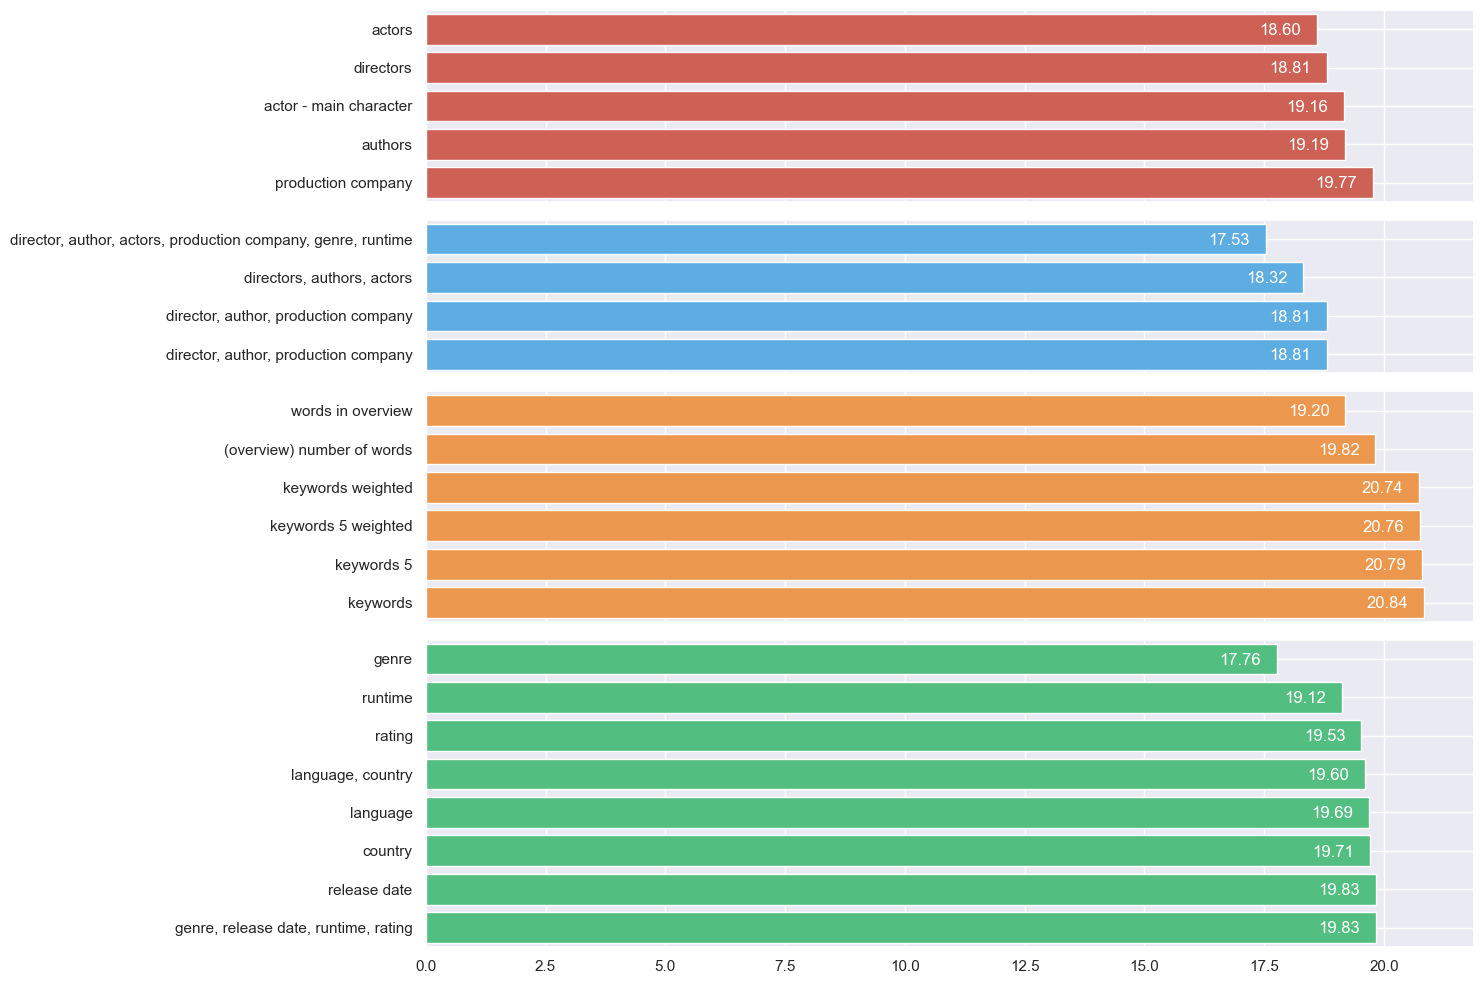

In [ ]:
color = ['#cd6155','#5dade2','#eb984e','#52be80', '#f7dc6f']
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex = True, gridspec_kw={'height_ratios': [5,4,6,8]})
for i, data in enumerate([actor_results, director_results, words_results, genre_results]):
  data = data.sort_values(by='rmse', ascending=False)
  ticks = [data.index] if type(data.index) == str else list(data.index)
  x = [0] if data.shape[0] == 2 else range(data.shape[0])
  y = list(range(len(ticks)))
  ax[i].barh(x, data['rmse'], align='center', color = color[i])
  ax[i].set_ylim(-0.5,max(x)+0.5)
  ax[i].set_yticks(y)
  ax[i].set_yticklabels(ticks)
  for index, value in enumerate(data.rmse):
    ax[i].text(value-1.2, index-0.15, f'{value:.2f}', c='white')
plt.tight_layout()
plt.show()

In [ ]:
data = [df.reset_index() for df in (actor_results, director_results, genre_results, words_results)]
best_results = [df[df['rmse'] == min(df['rmse'])].values.flatten().tolist() for df in data]
df_best_results = pd.DataFrame(best_results, columns = ['index', 'rmse']).sort_values(by='rmse', ascending=False)
df_best_results

,index,rmse
3,words in overview,19.197132
0,actors,18.600002
2,genre,17.763507
1,"director, author, actors, production company, ...",17.529656


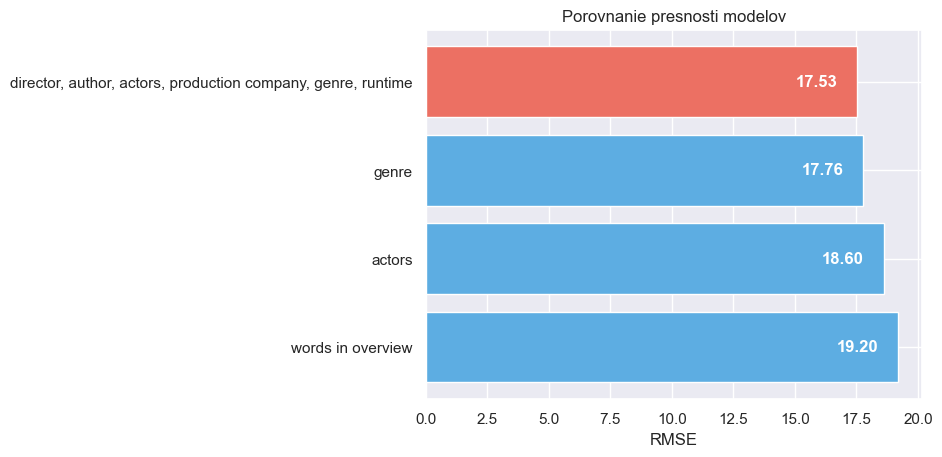

In [ ]:
fig, ax = plt.subplots()
colors = ['#ec7063' if i == min(df_best_results['rmse']) else '#5dade2' for i in df_best_results['rmse'] ]
ax.barh(range(df_best_results.shape[0]), df_best_results.rmse, align='center', color = colors)
ax.set_yticks(range(len(df_best_results['index'])))
ax.set_yticklabels(df_best_results['index'])
ax.set_xlabel('RMSE')
ax.set_title('Porovnanie presnosti modelov')
for index, value in enumerate(df_best_results.rmse):
    ax.text(value-2.5, index-0.05, f'{value:.2f}', c='white', fontweight='bold')

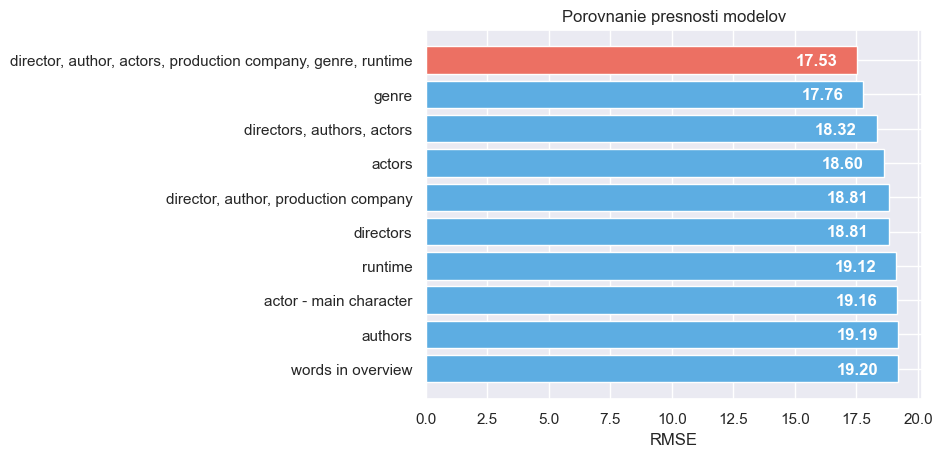

In [ ]:
best_all = df_results.sort_values(by='rmse').iloc[:10, :].sort_values(by='rmse', ascending=False)
fig, ax = plt.subplots()
colors = ['#ec7063' if i == min(best_all['rmse']) else '#5dade2' for i in best_all['rmse'] ]
ax.barh(range(best_all.shape[0]), best_all.rmse, align='center', color = colors)
ax.set_yticks(range(len(best_all.index)))
ax.set_yticklabels(best_all.index)
ax.set_xlabel('RMSE')
ax.set_title('Porovnanie presnosti modelov')
for index, value in enumerate(best_all.rmse):
    ax.text(value-2.5, index-0.15, f'{value:.2f}', c='white', fontweight='bold')